# NER with PEFT

In this notebook we will perform PEFT for a token classification task on the `CoNLLpp` dataset.

In [1]:
import json
import wandb
import torch
import random
import numpy as np
import pandas as pd

In [2]:
import seqeval
import evaluate
from datasets import load_dataset, Dataset

import transformers
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, get_peft_config, PeftConfig, PeftModel

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
sns.set_theme("notebook")
sns.set_style("white")

In [4]:
# fix random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)

In [5]:
project_name = "PEFT-NER"
access_tokens_path = "data/access_tokens.json"
model_ckpt = "distilroberta-base"
data_ckpt = "conllpp"

model_name = f"{model_ckpt}-finetuned-{data_ckpt}-peft_lora"
model_path = f"models/{model_name}"

In [7]:
raw_datasets = load_dataset("conllpp", trust_remote_code=True)

In [8]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [9]:
cols_to_remove = ["id", "pos_tags", "chunk_tags"]  # used for conll datasets

In [10]:
raw_datasets = raw_datasets.remove_columns(cols_to_remove)

In [11]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [12]:
label_names = raw_datasets["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, add_prefix_space=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [14]:
def align_labels_to_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

In [15]:
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"], is_split_into_words=True, truncation=True
    )

    new_labels = []
    all_labels = batch["ner_tags"]
    for i, labels in enumerate(all_labels):
        new_labels.append(align_labels_to_tokens(labels, tokenized_inputs.word_ids(i)))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [16]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [17]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [18]:
metric = evaluate.load("seqeval")

In [19]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    clean_labels = [[label_names[l] for l in ls if l != -100] for ls in labels]
    clean_preds = [
        [label_names[p] for (p, l) in zip(ps, ls) if l != -100]
        for (ps, ls) in zip(preds, labels)
    ]

    metrics = metric.compute(predictions=clean_preds, references=clean_labels)
    overall_metrics = {
        "accuracy": metrics["overall_accuracy"],
        "precision": metrics["overall_precision"],
        "recall": metrics["overall_recall"],
        "f1": metrics["overall_f1"],
    }
    return overall_metrics

In [20]:
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

In [21]:
model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from rich import print

In [23]:
print(model)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): RobertaIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): RobertaOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=9, bias=True)
)

In [24]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=None,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.TOKEN_CLS,
)

In [25]:
peft_model = get_peft_model(model, lora_config)

In [26]:
peft_model.print_trainable_parameters()

trainable params: 596,745 || all params: 82,131,474 || trainable%: 0.7266


In [27]:
print(peft_model)

PeftModelForTokenClassification(
  (base_model): LoraModel(
    (model): RobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-5): 6 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B): ParameterDict()
                    (lora_magnitude_vector): ModuleDict()
                  )
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B): ParameterDict()
                    (lora_magnitude_vector): ModuleDict()
                  )
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): RobertaSelfOutput(
                  (dense): Linear(in_features=768, out_features=768, bias=True)
                  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              )
              (intermediate): RobertaIntermediate(
                (dense): Linear(in_features=768, out_features=3072, bias=True)
                (intermediate_act_fn): GELUActivation()
              )
              (output): RobertaOutput(
                (dense): Linear(in_features=3072, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (classifier): ModulesToSaveWrapper(
        (original_module): Linear(in_features=768, out_features=9, bias=True)
        (modules_to_save): ModuleDict(
          (default): Linear(in_features=768, out_features=9, bias=True)
        )
      )
    )
  )
)

In [28]:
with open(access_tokens_path) as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hossam/.netrc


True

In [29]:
wandb.init(project=project_name, name=model_name)

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


In [31]:
args = TrainingArguments(
    model_path,
    overwrite_output_dir=True,
    num_train_epochs=3,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    seed=seed,
    data_seed=seed,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    weight_decay=1e-2,
    warmup_ratio=0.1,
)

In [32]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [33]:
trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [34]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.786500,0.144623,0.959728,0.774072,0.828004,0.800130
2,0.132000,0.104603,0.971050,0.834571,0.870246,0.852035
3,0.108400,0.096294,0.973275,0.837280,0.880680,0.858432


TrainOutput(global_step=2634, training_loss=0.25567841620361975, metrics={'train_runtime': 151.9632, 'train_samples_per_second': 277.192, 'train_steps_per_second': 17.333, 'total_flos': 518701507207992.0, 'train_loss': 0.25567841620361975, 'epoch': 3.0})

In [35]:
trainer.evaluate(tokenized_datasets["test"], metric_key_prefix="test")

{'test_loss': 0.11876904219388962,
 'test_accuracy': 0.9670346062052506,
 'test_precision': 0.8297229219143577,
 'test_recall': 0.8665380568221677,
 'test_f1': 0.8477309770953076,
 'test_runtime': 4.8244,
 'test_samples_per_second': 715.733,
 'test_steps_per_second': 44.772,
 'epoch': 3.0}

In [36]:
outs = trainer.predict(tokenized_datasets["test"])
preds, labels = outs.predictions, outs.label_ids
preds = preds.argmax(axis=-1)
clean_labels = [[label_names[l] for l in ls if l != -100] for ls in labels]
clean_preds = [
    [label_names[p] for (p, l) in zip(ps, ls) if l != -100]
    for (ps, ls) in zip(preds, labels)
]

In [37]:
print(
    seqeval.metrics.classification_report(
        clean_labels,
        clean_preds,
    )
)

precision    recall  f1-score   support

         LOC       0.86      0.89      0.88      1646
        MISC       0.62      0.70      0.66       723
         ORG       0.79      0.82      0.81      1715
         PER       0.95      0.96      0.95      1618

   micro avg       0.83      0.87      0.85      5702
   macro avg       0.80      0.84      0.82      5702
weighted avg       0.83      0.87      0.85      5702

In [38]:
all_labels = []
all_preds = []
for l, p in zip(clean_labels, clean_preds):
    all_labels.extend(l)
    all_preds.extend(p)

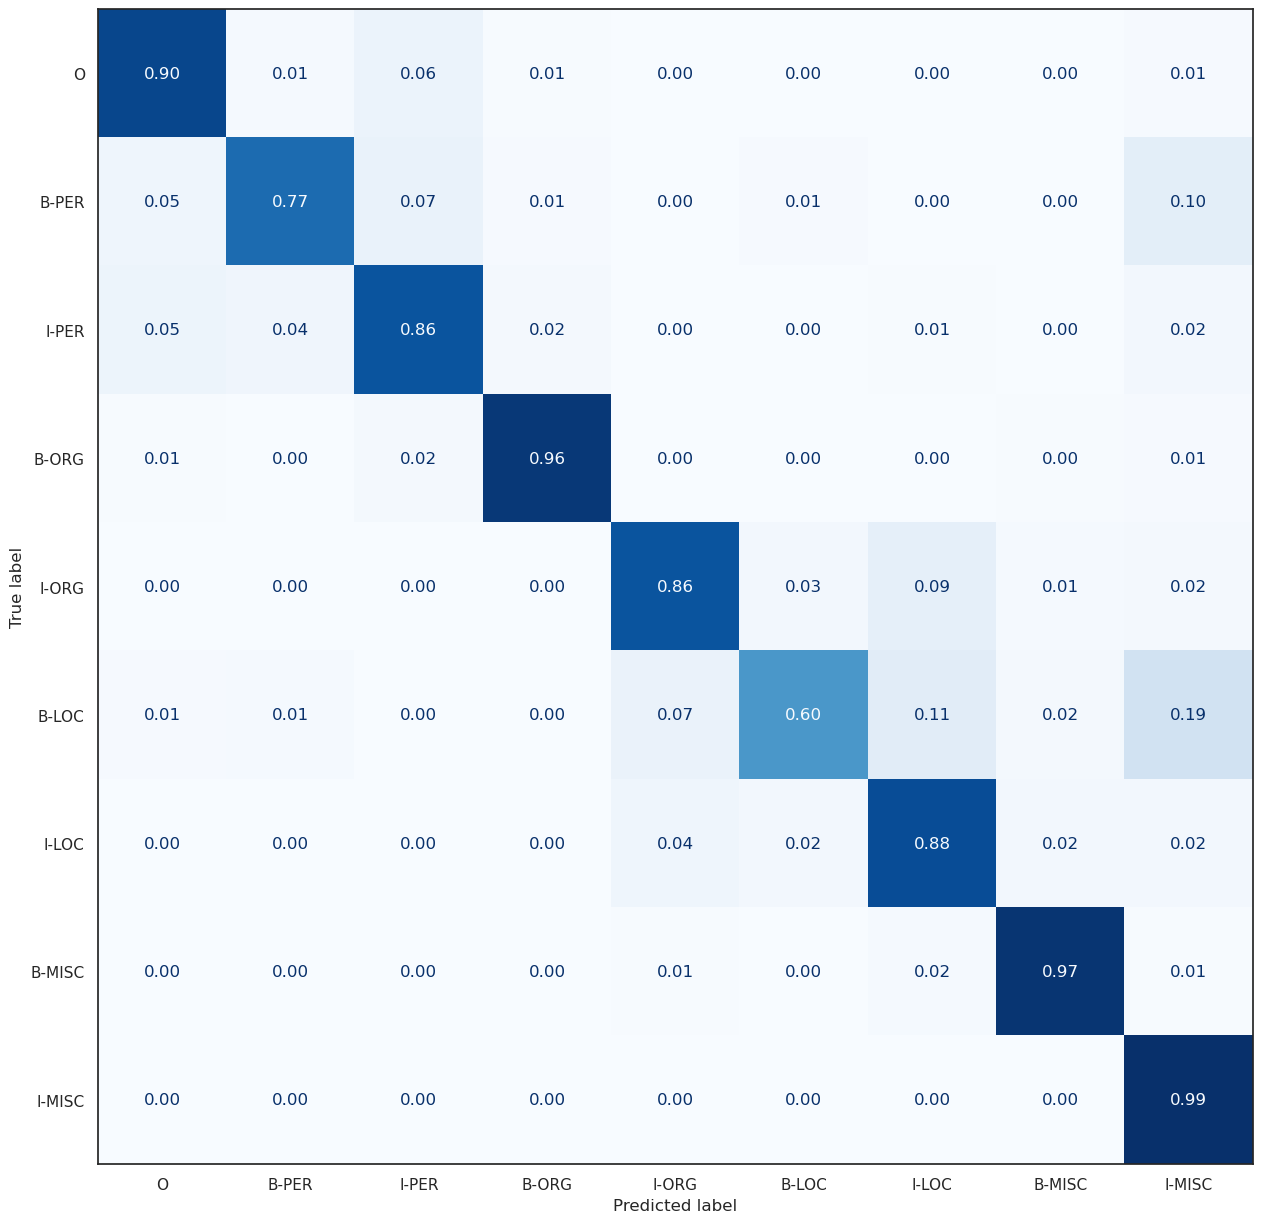

<Figure size 640x480 with 0 Axes>

In [39]:
_, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(
    all_labels,
    all_preds,
    normalize="true",
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues", colorbar=False, ax=ax, values_format=".2f")
plt.show()
plt.tight_layout()

In [40]:
trainer.save_model(model_path)

In [41]:
wandb.finish()

eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▂▁
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
test/accuracy,▁▁
test/f1,▁▁
test/loss,▁▁


In [42]:
config = PeftConfig.from_pretrained(model_path)

In [43]:
base_model = AutoModelForTokenClassification.from_pretrained(
    config.base_model_name_or_path, num_labels=len(label_names), id2label=id2label, label2id=label2id
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

In [45]:
model = PeftModel.from_pretrained(base_model, model_path, is_trainable=False)

In [46]:
model.print_trainable_parameters()

trainable params: 6,921 || all params: 82,131,474 || trainable%: 0.0084


In [47]:
ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The model 'PeftModelForTokenClassification' is not supported for ner. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GemmaForTokenClassification', 'Gemma2ForTokenClassification', 'GPT2ForTokenCl

In [48]:
ner("I live in Cairo and I love Egypt.")

[{'entity_group': 'LOC',
  'score': 0.99188095,
  'word': ' Cairo',
  'start': 10,
  'end': 15},
 {'entity_group': 'LOC',
  'score': 0.9921618,
  'word': ' Egypt',
  'start': 27,
  'end': 32}]

In [49]:
from spacy import displacy
from IPython.display import HTML

In [50]:
def create_scheme(text, outs):
    scheme = {}
    scheme["text"] = text
    scheme["ents"] = [
        {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
        for ent in outs
    ]
    scheme["title"] = None
    return scheme

In [51]:
index = 0
text = " ".join(raw_datasets["train"]["tokens"][index])
outs = ner(text)

In [52]:
_ = HTML(displacy.render(create_scheme(text, outs), style="ent", manual=True))